In [1]:
# import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_validate 
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import roc_auc_score

### 1. Cleaned Data

#### 1.1. Load data and display setting

In [2]:
diabetic = pd.read_csv('data.csv')

In [3]:
diabetic.shape

(101766, 50)

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
diabetic_df = diabetic.replace('?', np.nan)

In [6]:
# keep only first encounter for every unique patient
diabetic_df = diabetic_df.sort_values('encounter_id')
diabetic_df.drop_duplicates(subset = ['patient_nbr'], keep = 'first', inplace = True)

In [7]:
diabetic_df.shape

(71518, 50)

#### 1.2 Remove rows and coluns

In [8]:
# remove expired or hospice-bound patients
diabetic_df = diabetic_df[~diabetic_df['discharge_disposition_id'].isin([11,13,14,19,20,21])]

In [9]:
# remove unknown-gender patients
diabetic_df.drop(diabetic_df.loc[diabetic_df.gender=='Unknown/Invalid'].index,inplace=True)

In [10]:
# remove encounter ID, patient NBR, weight, medical specialty, and payer code
diabetic_df.drop(['encounter_id','patient_nbr','weight','medical_specialty','payer_code'],\
                 axis = 1, inplace = True)

In [11]:
# discretize ID columns
diabetic_df['admission_type_id'] = diabetic_df['admission_type_id'].astype('str')
diabetic_df['admission_source_id'] = diabetic_df['admission_source_id'].astype('str')
diabetic_df['discharge_disposition_id'] = diabetic_df['discharge_disposition_id'].astype('str')

In [12]:
diabetic_df.shape

(69970, 45)

### 2. Feature Engineering

#### 2.1 Categorical to Numeric

In [13]:
# binarize target variable: readmitted < 30 days or other
diabetic_df['readmit_30d'] = (diabetic_df['readmitted'] == '<30')

In [14]:
# convert age to a continuous variable
diabetic_df['age_num'] = diabetic_df['age'].replace(
    ['[0-10)','[10-20)','[20-30)','[30-40)','[40-50)','[50-60)','[60-70)','[70-80)','[80-90)','[90-100)'],
    [0,10,20,30,40,50,60,70,80,90])

#### 2.2 Diagnose Features

In [15]:
# keep main disease class only
diabetic_df['diag_1'] = diabetic_df['diag_1'].str.split('.', expand = True).drop(1, axis = 1)
diabetic_df['diag_2'] = diabetic_df['diag_2'].str.split('.', expand = True).drop(1, axis = 1)
diabetic_df['diag_3'] = diabetic_df['diag_3'].str.split('.', expand = True).drop(1, axis = 1)

In [16]:
# create a binary variable for each diagnosis in diag_1,2, or 3 that has sample size >500
count_1 = diabetic_df['diag_1'].value_counts()
index_1 = count_1[count_1>=500].index.tolist()

count_2 = diabetic_df['diag_2'].value_counts()
index_2 = count_2[count_2>=500].index.tolist()

count_3 = diabetic_df['diag_3'].value_counts()
index_3 = count_3[count_3>=500].index.tolist()

diagnoses = set(index_1 + index_2 + index_3)

for d in diagnoses:
    diabetic_df[d+'_diag'] = ((diabetic_df['diag_1']==d)|
                              (diabetic_df['diag_2']==d)|
                              (diabetic_df['diag_3']==d))

#### 2.3  Medication Features

In [17]:
# binarize medication features with minority classes > 500 samples: used/not used
for col in ['metformin','repaglinide','glimepiride','glipizide', 'glyburide','pioglitazone',
            'rosiglitazone','insulin']:
    diabetic_df[col+'_used'] = np.where(diabetic_df[col]=='No', False, True)

In [18]:
### 2.4 removing columns <500

#### 2.4 finalizing dataset and dummifying categorical variables

In [19]:
# remove features used to engineer new features
diabetic_final = diabetic_df.drop(['age',
                                   'diag_1','diag_2','diag_3',
                                   'metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
                                   'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
                                   'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide',
                                   'citoglipton','insulin','glyburide-metformin','glipizide-metformin',
                                   'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone',
                                   'readmitted'],
                                 axis = 1)

#### 2.5 Export dataset

In [20]:
# dummify features
diabetic_final = pd.get_dummies(diabetic_final, drop_first = True)
diabetic_final.shape

(69970, 119)

In [21]:
diabetic_final.to_csv('diabetic_model_set.csv',  index = False)

 _____________________________________________________________________________________


In [22]:
data = pd.read_csv('diabetic_model_set.csv')

In [23]:
data

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmit_30d,age_num,493_diag,820_diag,518_diag,411_diag,433_diag,585_diag,272_diag,250_diag,715_diag,562_diag,414_diag,278_diag,428_diag,786_diag,434_diag,V45_diag,296_diag,584_diag,722_diag,285_diag,435_diag,424_diag,486_diag,491_diag,780_diag,425_diag,996_diag,574_diag,401_diag,440_diag,410_diag,707_diag,599_diag,413_diag,496_diag,560_diag,305_diag,682_diag,276_diag,577_diag,41_diag,V57_diag,403_diag,38_diag,427_diag,metformin_used,repaglinide_used,glimepiride_used,glipizide_used,glyburide_used,pioglitazone_used,rosiglitazone_used,insulin_used,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_2,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_2,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_No,diabetesMed_Yes
0,13,68,2,28,0,0,0,8,False,80,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,True,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
1,12,33,3,18,0,0,0,8,False,90,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
2,1,51,0,8,0,0,0,5,False,40,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1
3,9,47,2,17,0,0,0,9,False,40,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1
4,3,31,6,16,0,0,0,9,False,50,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [24]:
data.drop(['admission_type_id_4',
 'admission_type_id_7',
 'admission_type_id_8',
 'discharge_disposition_id_10',
 'discharge_disposition_id_12',
 'discharge_disposition_id_15',
 'discharge_disposition_id_16',
 'discharge_disposition_id_17',
 'discharge_disposition_id_23',
 'discharge_disposition_id_24',
 'discharge_disposition_id_27',
 'discharge_disposition_id_28',
 'discharge_disposition_id_7',
 'discharge_disposition_id_8',
 'discharge_disposition_id_9',
 'admission_source_id_10',
 'admission_source_id_11',
 'admission_source_id_13',
 'admission_source_id_14',
 'admission_source_id_20',
 'admission_source_id_22',
 'admission_source_id_25',
 'admission_source_id_3',
 'admission_source_id_8',
 'admission_source_id_9'], axis = 1, inplace = True)

In [25]:
diag_variables = ['996_diag', '820_diag',
       '585_diag', '599_diag', '682_diag', '413_diag', '433_diag', '574_diag',
       '296_diag', '411_diag', '584_diag', '486_diag', '496_diag', '440_diag',
       '562_diag', '305_diag', '285_diag', 'V45_diag', '577_diag', '410_diag',
       '414_diag', '560_diag', '780_diag', '278_diag', '722_diag', '38_diag',
       '403_diag', '250_diag', '786_diag', '401_diag', '424_diag', 'V57_diag',
       '276_diag', '435_diag', '427_diag', '715_diag', '518_diag', '272_diag',
       '434_diag', '425_diag', '428_diag', '491_diag', '707_diag', '41_diag',
       '493_diag']

In [26]:
diag_dict = {False : 0, True:1}
for diag_col in diag_variables:
    data[diag_col].replace(diag_dict, inplace = True)

In [27]:
med_variables = ['metformin_used', 'repaglinide_used', 'glimepiride_used',
       'glipizide_used', 'glyburide_used', 'pioglitazone_used',
       'rosiglitazone_used', 'insulin_used']
med_dict = {False : 0, True:1}
for med_col in med_variables:
    data[med_col].replace(med_dict, inplace = True)

In [28]:
readmitted_dict = {True : 1, False: 0}
data.readmit_30d.replace(readmitted_dict, inplace = True)

In [29]:
data

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmit_30d,age_num,493_diag,820_diag,518_diag,411_diag,433_diag,585_diag,272_diag,250_diag,715_diag,562_diag,414_diag,278_diag,428_diag,786_diag,434_diag,V45_diag,296_diag,584_diag,722_diag,285_diag,435_diag,424_diag,486_diag,491_diag,780_diag,425_diag,996_diag,574_diag,401_diag,440_diag,410_diag,707_diag,599_diag,413_diag,496_diag,560_diag,305_diag,682_diag,276_diag,577_diag,41_diag,V57_diag,403_diag,38_diag,427_diag,metformin_used,repaglinide_used,glimepiride_used,glipizide_used,glyburide_used,pioglitazone_used,rosiglitazone_used,insulin_used,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,admission_type_id_2,admission_type_id_3,admission_type_id_5,admission_type_id_6,discharge_disposition_id_18,discharge_disposition_id_2,discharge_disposition_id_22,discharge_disposition_id_25,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,admission_source_id_17,admission_source_id_2,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_No,diabetesMed_Yes
0,13,68,2,28,0,0,0,8,0,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1
1,12,33,3,18,0,0,0,8,0,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1
2,1,51,0,8,0,0,0,5,0,40,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1
3,9,47,2,17,0,0,0,9,0,40,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1
4,3,31,6,16,0,0,0,9,0,50,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69965,9,50,2,33,0,0,0,9,0,70,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1
69966,14,73,6,26,0,1,0,9,0,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1
69967,2,46,6,17,1,1,1,9,0,60,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1
69968,5,76,1,22,0,1,0,9,0,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1


In [30]:
data.to_csv('data_final.csv',  index = False)

In [31]:
top_43_features = ['number_inpatient', 'discharge_disposition_id_22', 'time_in_hospital',
       'discharge_disposition_id_3', 'age_num', 'num_medications',
       'number_diagnoses', 'discharge_disposition_id_5', 'num_lab_procedures',
       '434_diag', '786_diag', '403_diag', 'diabetesMed_Yes',
       'number_emergency', '401_diag', 'discharge_disposition_id_2',
       '428_diag', 'insulin_used', 'num_procedures', '440_diag', '707_diag',
       '272_diag', 'number_outpatient', '820_diag', 'admission_type_id_3',
       '278_diag', 'discharge_disposition_id_6', 'change_No', '414_diag',
       'admission_source_id_7', 'race_Other', 'admission_type_id_6',
       '250_diag', '305_diag', 'metformin_used', 'gender_Male', '722_diag',
       'race_Caucasian', 'glipizide_used', 'admission_type_id_5',
       'A1Cresult_None', '574_diag', 'pioglitazone_used','readmit_30d']

In [32]:
data1 = data[top_43_features]

In [33]:
data1.to_csv('data_top.csv',  index = False)

## 3. Modeling

### 3.1 Train, Test set split

In [34]:
X = data.drop (['readmit_30d'], axis=1)
y = data['readmit_30d']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [36]:
feature_names = X_train.columns

In [37]:
y_train.value_counts() / len(y_train) * 100

0    91.028298
1     8.971702
Name: readmit_30d, dtype: float64

In [38]:
## standard scaler

In [39]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

### 3.2 Logistic regression modeling

### 3.2.1 Logistic Regression Model Fitting

In [40]:
logistic = LogisticRegression(solver='liblinear',
                              penalty='l2',
                              C=0.01,
                              random_state=42,
                              class_weight = 'balanced')

logistic.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight='balanced', random_state=42,
                   solver='liblinear')

In [41]:
from sklearn.linear_model import LogisticRegression
y_pred = logistic.predict(X_test)

### 3.2.4 Grid Search

In [42]:
from sklearn.model_selection import cross_validate 
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import GridSearchCV 
pipe_logistic = make_pipeline(LogisticRegression(random_state=42))
param_range = [0.01, 0.1, 1.0, 10, 100, 200] 

param_grid = [{'logisticregression__C': param_range}] 

gs = GridSearchCV(estimator=pipe_logistic,
                  param_grid=param_grid, 
                  scoring='roc_auc', 
                  cv=5,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.6269290987224556
{'logisticregression__C': 0.1}


In [43]:
# # grid search class weights with decision tree for imbalance classification
# from sklearn.model_selection import RepeatedStratifiedKFold

# balance = [{0:1,1:1}, {0:1,1:2}, {0:1,1:3}]
# param_grid = dict(class_weight=balance)

# grid = GridSearchCV(estimator=LogisticRegression(random_state=42), 
#                     param_grid=param_grid, 
#                     n_jobs=-1, 
#                     cv= 3, 
#                     scoring='roc_auc',)
# grid_result = grid.fit(X_train, y_train)

# # report the best configuration
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# # report all configurations
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [44]:
from sklearn.metrics import roc_auc_score

In [45]:
y

0        0
1        0
2        0
3        0
4        0
        ..
69965    0
69966    0
69967    0
69968    0
69969    0
Name: readmit_30d, Length: 69970, dtype: int64

In [46]:
roc_auc_score(y_test, y_pred)

0.6034815444243905

In [47]:
print(gs.score(X_train, y_train)) 
print(gs.score(X_test, y_test)) 

0.6330947243050231
0.6136412666314097


### 3.2.2 Confusion Matrix

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],8534,4205
True[1],581,674


In [49]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test, y_pred))
print('accuracy_score: %.3f' % accuracy_score(y_test, y_pred))
print('precision_score: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('recall_score: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('f1_score: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

accuracy_score: 0.658
precision_score: 0.138
recall_score: 0.537
f1_score: 0.220


### 3.2.3 precision - recall curve

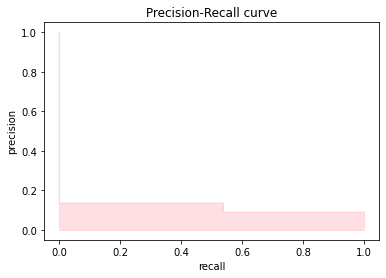

In [50]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.figure()
plt.step(recall, precision, color = "pink", alpha = 0.3, where = 'post')
plt.fill_between(recall, precision, step = 'post', alpha=0.5, color = "pink")
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall curve');

### 3.2.5  Logistic Regression — Feature Selection(RFECV)

In [51]:
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=logistic, step=1, cv= 5, scoring='roc_auc')
rfecv.fit(X_train, y_train)

RFECV(cv=5,
      estimator=LogisticRegression(C=0.01, class_weight='balanced',
                                   random_state=42, solver='liblinear'),
      scoring='roc_auc')

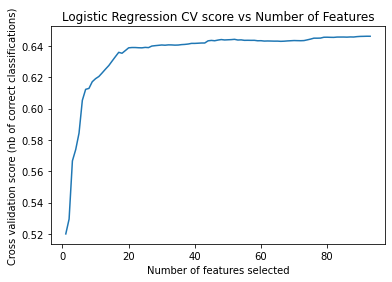

In [52]:
# check  number of features which gives the maximum accuracy
plt.figure()
plt.title('Logistic Regression CV score vs Number of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [53]:
feature_importance = list(zip(feature_names, rfecv.support_))
new_features = []
for key,value in enumerate(feature_importance):
    if(value[1]) == True:
        new_features.append(value[0])
print(new_features)

['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'age_num', '493_diag', '820_diag', '518_diag', '411_diag', '433_diag', '585_diag', '272_diag', '250_diag', '715_diag', '562_diag', '414_diag', '278_diag', '428_diag', '786_diag', '434_diag', 'V45_diag', '296_diag', '584_diag', '722_diag', '285_diag', '435_diag', '424_diag', '486_diag', '491_diag', '780_diag', '425_diag', '996_diag', '574_diag', '401_diag', '440_diag', '410_diag', '707_diag', '599_diag', '413_diag', '496_diag', '560_diag', '305_diag', '682_diag', '276_diag', '577_diag', '41_diag', 'V57_diag', '403_diag', '38_diag', '427_diag', 'metformin_used', 'repaglinide_used', 'glimepiride_used', 'glipizide_used', 'glyburide_used', 'pioglitazone_used', 'rosiglitazone_used', 'insulin_used', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other', 'gender_Male', 'admission_type_id_2', 'admission_type_id_3', 'admission_type_id_5', 'admissio

In [54]:
# feature_coef = pd.DataFrame({'feature':feature_names,'coef':coef}).sort_values(by='coef')
# feature_coef.plot.barh(x= 'feature', y='coef',figsize = (10,20))

In [55]:
coef = logistic.coef_[0]
for n,v in zip(feature_names, coef):
    print('Feature : %s, Score %.3f' % (n,v))

Feature : time_in_hospital, Score 0.022
Feature : num_lab_procedures, Score 0.002
Feature : num_procedures, Score 0.002
Feature : num_medications, Score -0.000
Feature : number_outpatient, Score 0.001
Feature : number_emergency, Score 0.142
Feature : number_inpatient, Score 0.332
Feature : number_diagnoses, Score 0.028
Feature : age_num, Score 0.004
Feature : 493_diag, Score -0.119
Feature : 820_diag, Score 0.100
Feature : 518_diag, Score -0.118
Feature : 411_diag, Score 0.027
Feature : 433_diag, Score 0.002
Feature : 585_diag, Score -0.038
Feature : 272_diag, Score -0.210
Feature : 250_diag, Score 0.035
Feature : 715_diag, Score -0.099
Feature : 562_diag, Score 0.046
Feature : 414_diag, Score -0.048
Feature : 278_diag, Score -0.192
Feature : 428_diag, Score 0.130
Feature : 786_diag, Score -0.351
Feature : 434_diag, Score 0.329
Feature : V45_diag, Score -0.116
Feature : 296_diag, Score 0.074
Feature : 584_diag, Score 0.005
Feature : 722_diag, Score -0.290
Feature : 285_diag, Score -0.1

### check cross validaition

In [56]:
scores = cross_validate(estimator=logistic, 
                        X=X_train, 
                        y=y_train, 
                        scoring='roc_auc', 
                        cv=10, 
                        n_jobs=-1,
                        return_train_score=False)

In [57]:
print('roc_auc mean & std : %.3f +/- %.3f' % (np.mean(scores['test_score']), 
                                 np.std(scores['test_score'])))

roc_auc mean & std : 0.647 +/- 0.011


### 3.3 Decision Tree modeling

### 3.3.1 Decision Tree model Fitting

In [58]:
X = data.drop (['readmit_30d'], axis=1)
y = data['readmit_30d']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [59]:
tree = DecisionTreeClassifier(criterion='gini',
                              max_depth= 5, 
                              random_state=42, 
                              class_weight='balanced')
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [60]:
y_pred = tree.predict(X_test)

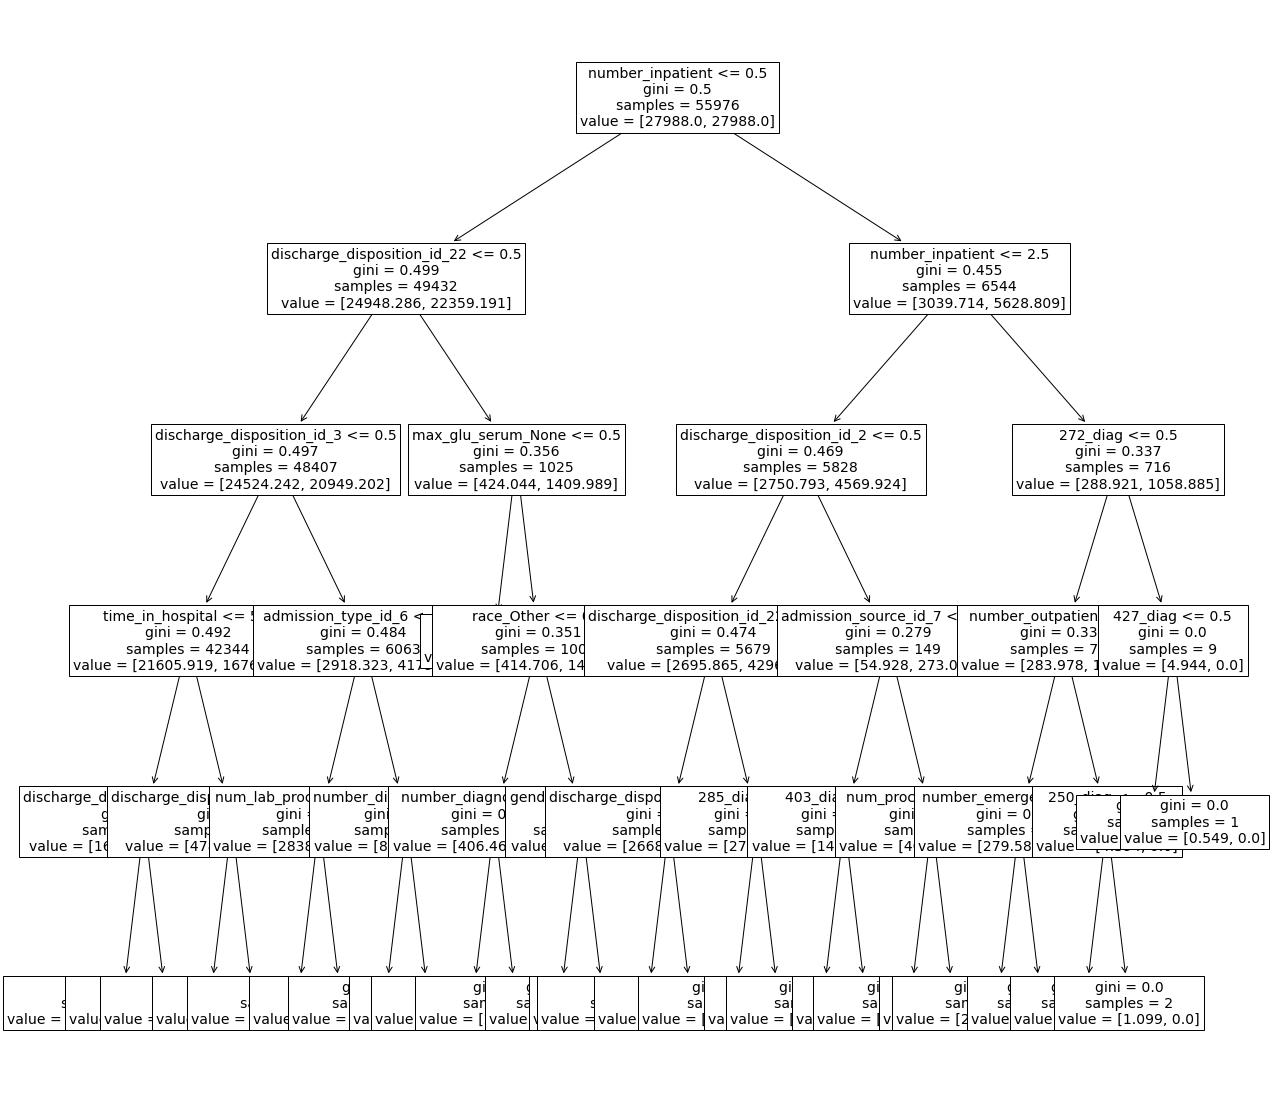

In [61]:
from sklearn.tree import plot_tree
# feature_names=X.column.tolist()
plt.figure(figsize=(20,20))
plot_tree(tree, feature_names=X_train.columns, fontsize=14)
plt.show()

In [62]:
# x = range(1,10)
# y1 = [DecisionTreeClassifier(max_depth=i, random_state=123).fit(X_train, y_train).score(X_train, y_train) for i in x]
# y2 = [DecisionTreeClassifier(max_depth=i, random_state=123).fit(X_train, y_train).score(X_test, y_test) for i in x]
# plt.plot(x,y1,label='train')
# plt.plot(x,y2,label='test')
# plt.xlabel('depth of tree')
# plt.ylabel('accuracy')
# plt.legend()
# plt.show()

### Grid Search

In [63]:
# grid search class weights with decision tree for imbalance classification
from numpy import mean
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier


params = {'max_depth': [3,4,5,10], 'n_estimators': [100, 150, 200]}
grid = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                    param_grid=params, 
                    n_jobs=-1, 
                    cv= 5, 
                    scoring='roc_auc',
                    verbose = 1)
grid.fit(X_train, y_train)

grid = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv= 5, 
                    scoring='roc_auc',)
grid_result = grid.fit(X_train, y_train)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.1min finished


ValueError: Invalid parameter logisticregression for estimator DecisionTreeClassifier(random_state=42). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
roc_auc_score(y_test, y_pred)

In [ ]:
print(grid_result.score(X_test, y_test)) 

In [ ]:
# # grid search class weights with decision tree for imbalance classification
# from numpy import mean
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.tree import DecisionTreeClassifier

# # define grid
# balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
# param_grid = dict(class_weight=balance)

# # define evaluation procedure
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# # define grid search
# grid = GridSearchCV(estimator=DecisionTreeClassifier(random_state=1), param_grid=param_grid, n_jobs=-1, cv= cv, scoring='roc_auc')

# #execute the grid search
# grid_result = grid.fit(X_train, y_train)

# # report the best configuration
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# # report all configurations
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

### 3.3.2  Confusion Matrix

In [ ]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

In [ ]:
print('accuracy_score: %.3f' % accuracy_score(y_test, y_pred))
print('precision_score: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('recall_score: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('f1_score: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))
print('ROCAUC score:',roc_auc_score(y_test, y_pred))

In [ ]:
y_pred_p = tree.predict_proba(X_test)

In [ ]:
### 3.3.3 precision recall curve

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.figure()
plt.step(recall, precision, color = "pink", alpha = 0.3, where = 'post')
plt.fill_between(recall, precision, step = 'post', alpha=0.5, color = "pink")
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall curve');

In [ ]:
print("Feature importances:\\n{0}".format(np.round(tree.feature_importances_, 3)))

In [ ]:
for name, value in zip(X_train.columns , tree.feature_importances_): 
    print('{} : {:.3f}'.format(name, value)) 

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(x=tree.feature_importances_ , y=X_train.columns)
plt.show()

### 3.3.5 Check cross validation

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
scores = cross_validate(estimator=tree, 
                        X=X_train, 
                        y=y_train, 
                        scoring='roc_auc', 
                        cv=10, 
                        n_jobs=-1,
                        return_train_score=False)

In [ ]:
scores

### 3.4 Random Forest

### 3.4.1 Random Forest Model fitting

In [ ]:
X = data.drop (['readmit_30d'], axis=1)
y = data['readmit_30d']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=500, 
                                random_state=42,
                               class_weight = 'balanced',
                               max_depth = 5)

In [ ]:
forest.fit(X_train, y_train)

In [ ]:
y_pred = forest.predict(X_test)

### Grid Search

In [ ]:
params = {'class_weight': [None, 'balanced'], 'max_depth': [3,5,10], 'n_estimators': [100, 150, 200]}
grid = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                    param_grid=params, 
                    n_jobs=-1, 
                    cv= 5, 
                    scoring='roc_auc',
                    verbose = 1)
grid.fit(X_train, y_train)

In [ ]:
grid.best_params_

In [ ]:
y_pred = grid.predict(X_test)

In [ ]:
roc_auc_score(y_test, y_pred)

In [ ]:
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
roc_auc_score(y_test, y_pred)

### confusion Matrix

In [ ]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

In [ ]:
print('accuracy_score: %.3f' % accuracy_score(y_test, y_pred))
print('precision_score: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('recall_score: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('f1_score: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

### precision recall curve

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.figure()
plt.step(recall, precision, color = "pink", alpha = 0.3, where = 'post')
plt.fill_between(recall, precision, step = 'post', alpha=0.5, color = "pink")
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall curve');

### Fearure importance

In [ ]:
feat_labels = X_train.columns

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [ ]:
feat_labels = X_train.columns

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
feature_importances = pd.DataFrame(forest.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

In [ ]:
feature_importances.index

In [ ]:
#feature_importances[feature_importances.importance >= np.median(feature_importances.importance)]#.index

### RandomForest : class weight  = "balanced_subsample"

In [ ]:
X = data.drop (['readmit_30d'], axis=1)
y = data['readmit_30d']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_sub = RandomForestClassifier(n_estimators=500, 
                                random_state=42,
                               class_weight = 'balanced_subsample',
                               max_depth = 5)

In [ ]:
forest_sub.fit(X_train, y_train)

In [ ]:
y_pred = forest_sub.predict(X_test)

#### GridSearch

In [ ]:
params = {'n_estimators':[100,200]}
grid = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv= 5, 
                    scoring='roc_auc',)
grid_result = grid.fit(X_train, y_train)

In [ ]:
print(grid_result.best_params_)
print(grid_result.best_score_)

In [ ]:
roc_auc_score(y_test, y_pred)

In [ ]:
print(grid_result.score(X_train, y_train)) 
print(grid_result.score(X_test, y_test)) 

### Confusion Matrix

In [ ]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

In [ ]:
print('accuracy_score: %.3f' % accuracy_score(y_test, y_pred))
print('precision_score: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('recall_score: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('f1_score: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

### precision recall curve

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.figure()
plt.step(recall, precision, color = "pink", alpha = 0.3, where = 'post')
plt.fill_between(recall, precision, step = 'post', alpha=0.5, color = "pink")
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall curve');

In [ ]:
feat_labels = X_train.columns

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
feature_importances = pd.DataFrame(forest.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances 

In [ ]:
feature_importances.index

In [ ]:
feature_importances[feature_importances.importance >= np.median(feature_importances.importance)]#.index

In [ ]:
feature_importances.index.to_list

### 3.5 Gradient Boosting

In [ ]:
# Boosting model has same problem..High training accuracy, but low tests accuracy.
# It seems overfitting problem

### Train, Test split

In [ ]:
top_43_features = ['number_inpatient', 'discharge_disposition_id_22', 'time_in_hospital',
       'discharge_disposition_id_3', 'age_num', 'num_medications',
       'number_diagnoses', 'discharge_disposition_id_5', 'num_lab_procedures',
       '434_diag', '786_diag', '403_diag', 'diabetesMed_Yes',
       'number_emergency', '401_diag', 'discharge_disposition_id_2',
       '428_diag', 'insulin_used', 'num_procedures', '440_diag', '707_diag',
       '272_diag', 'number_outpatient', '820_diag', 'admission_type_id_3',
       '278_diag', 'discharge_disposition_id_6', 'change_No', '414_diag',
       'admission_source_id_7', 'race_Other', 'admission_type_id_6',
       '250_diag', '305_diag', 'metformin_used', 'gender_Male', '722_diag',
       'race_Caucasian', 'glipizide_used', 'admission_type_id_5',
       'A1Cresult_None', '574_diag', 'pioglitazone_used']

In [ ]:
X = data[top_43_features]
y= data['readmit_30d']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier(n_estimators = 100, random_state=42,learning_rate=1.0 )
gbm.fit(X_train, y_train)

In [ ]:
y_pred = gbm.predict(X_test)

In [ ]:
params = {'n_estimators':[100, 150, 200, 250], 'learning_rate' : [0.1, 0.5, 0.01]}
grid = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), 
                    param_grid=params, 
                    n_jobs=-1, 
                    cv= 5, 
                    scoring='roc_auc',
                    verbose = 1)
grid_result = grid.fit(X_train, y_train)

### Confusion Matrix

In [ ]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

In [ ]:
print('precision_score: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('recall_score: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('f1_score: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))


In [ ]:
print(grid_result.best_params_)
print(grid_result.best_score_)

In [ ]:
print(grid_result.score(X_train, y_train)) 
print(grid_result.score(X_test, y_test)) 

In [ ]:
roc_auc_score(y_test, y_pred)

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

In [ ]:
plt.figure()
plt.step(recall, precision, color = "pink", alpha = 0.3, where = 'post')
plt.fill_between(recall, precision, step = 'post', alpha=0.5, color = "pink")
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall curve');
params = {'n_estimators':[100,200]}

### 3.6 XGBClassifier

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

In [ ]:
y_pred = gbm.predict(X_test)

In [ ]:
weights = [1, 10, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)
grid = GridSearchCV(estimator=xgb, param_grid=param_grid, n_jobs=-1, cv=5, scoring='roc_auc')
grid_result = grid.fit(X_train, y_train)

In [ ]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

In [ ]:
print('precision_score: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('recall_score: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('f1_score: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

In [ ]:
print(grid_result.best_params_)
print(grid_result.best_score_)

In [ ]:
y_pred = gbm.predict(X_test)

In [ ]:
print(grid_result.score(X_test, y_test)) 

In [ ]:
roc_auc_score(y_test, y_pred)

In [ ]:
y_predict = grid_result.best_estimator_.predict(X_test)

In [ ]:
print(grid_result.score(X_train, y_train)) 
print(grid_result.score(X_test, y_test)) 